# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Clustering and filtering doublets

## Libraries

In [2]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [3]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [4]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_T0_CD3pos.rds")))

### First clustering to localize doublets

In [5]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:20)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14043
Number of edges: 467763

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9517
Number of communities: 9
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14043
Number of edges: 467763

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9304
Number of communities: 11
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14043
Number of edges: 467763

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9103
Number of communities: 13
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14043
Number of edges: 467763

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8908
Number of communities: 13
Elapsed time: 2 seconds
Modularity Op

In [6]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

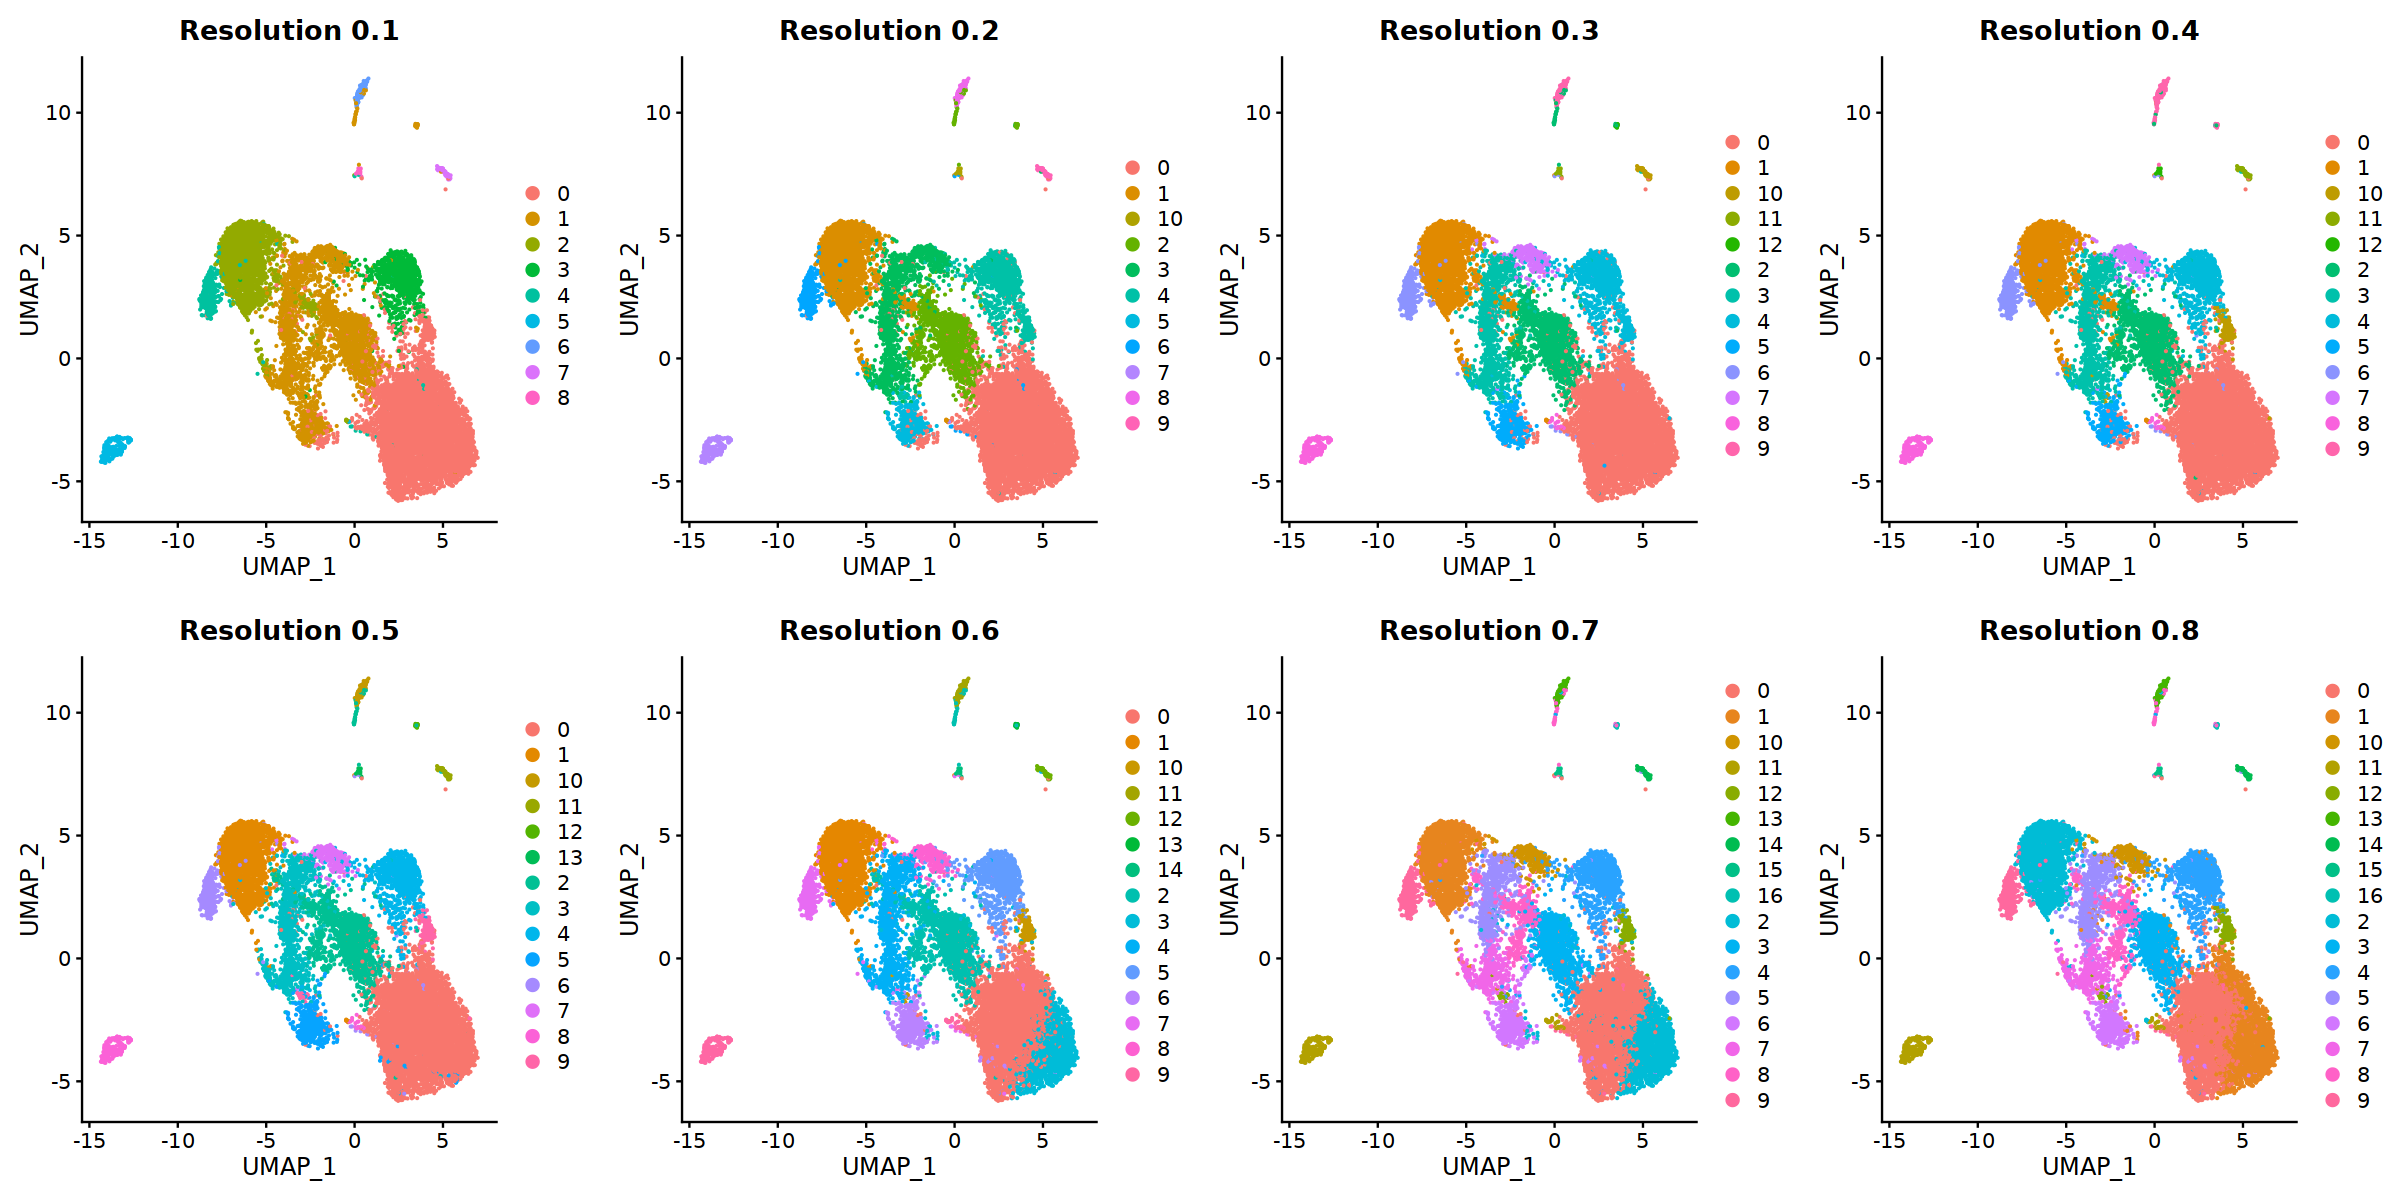

In [7]:
options(repr.plot.width = 20, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [8]:
markers = c("CD3E", "CD3G","CD4","CD8A", "CD8B",
            "SELL","GZMK","FOXP3")

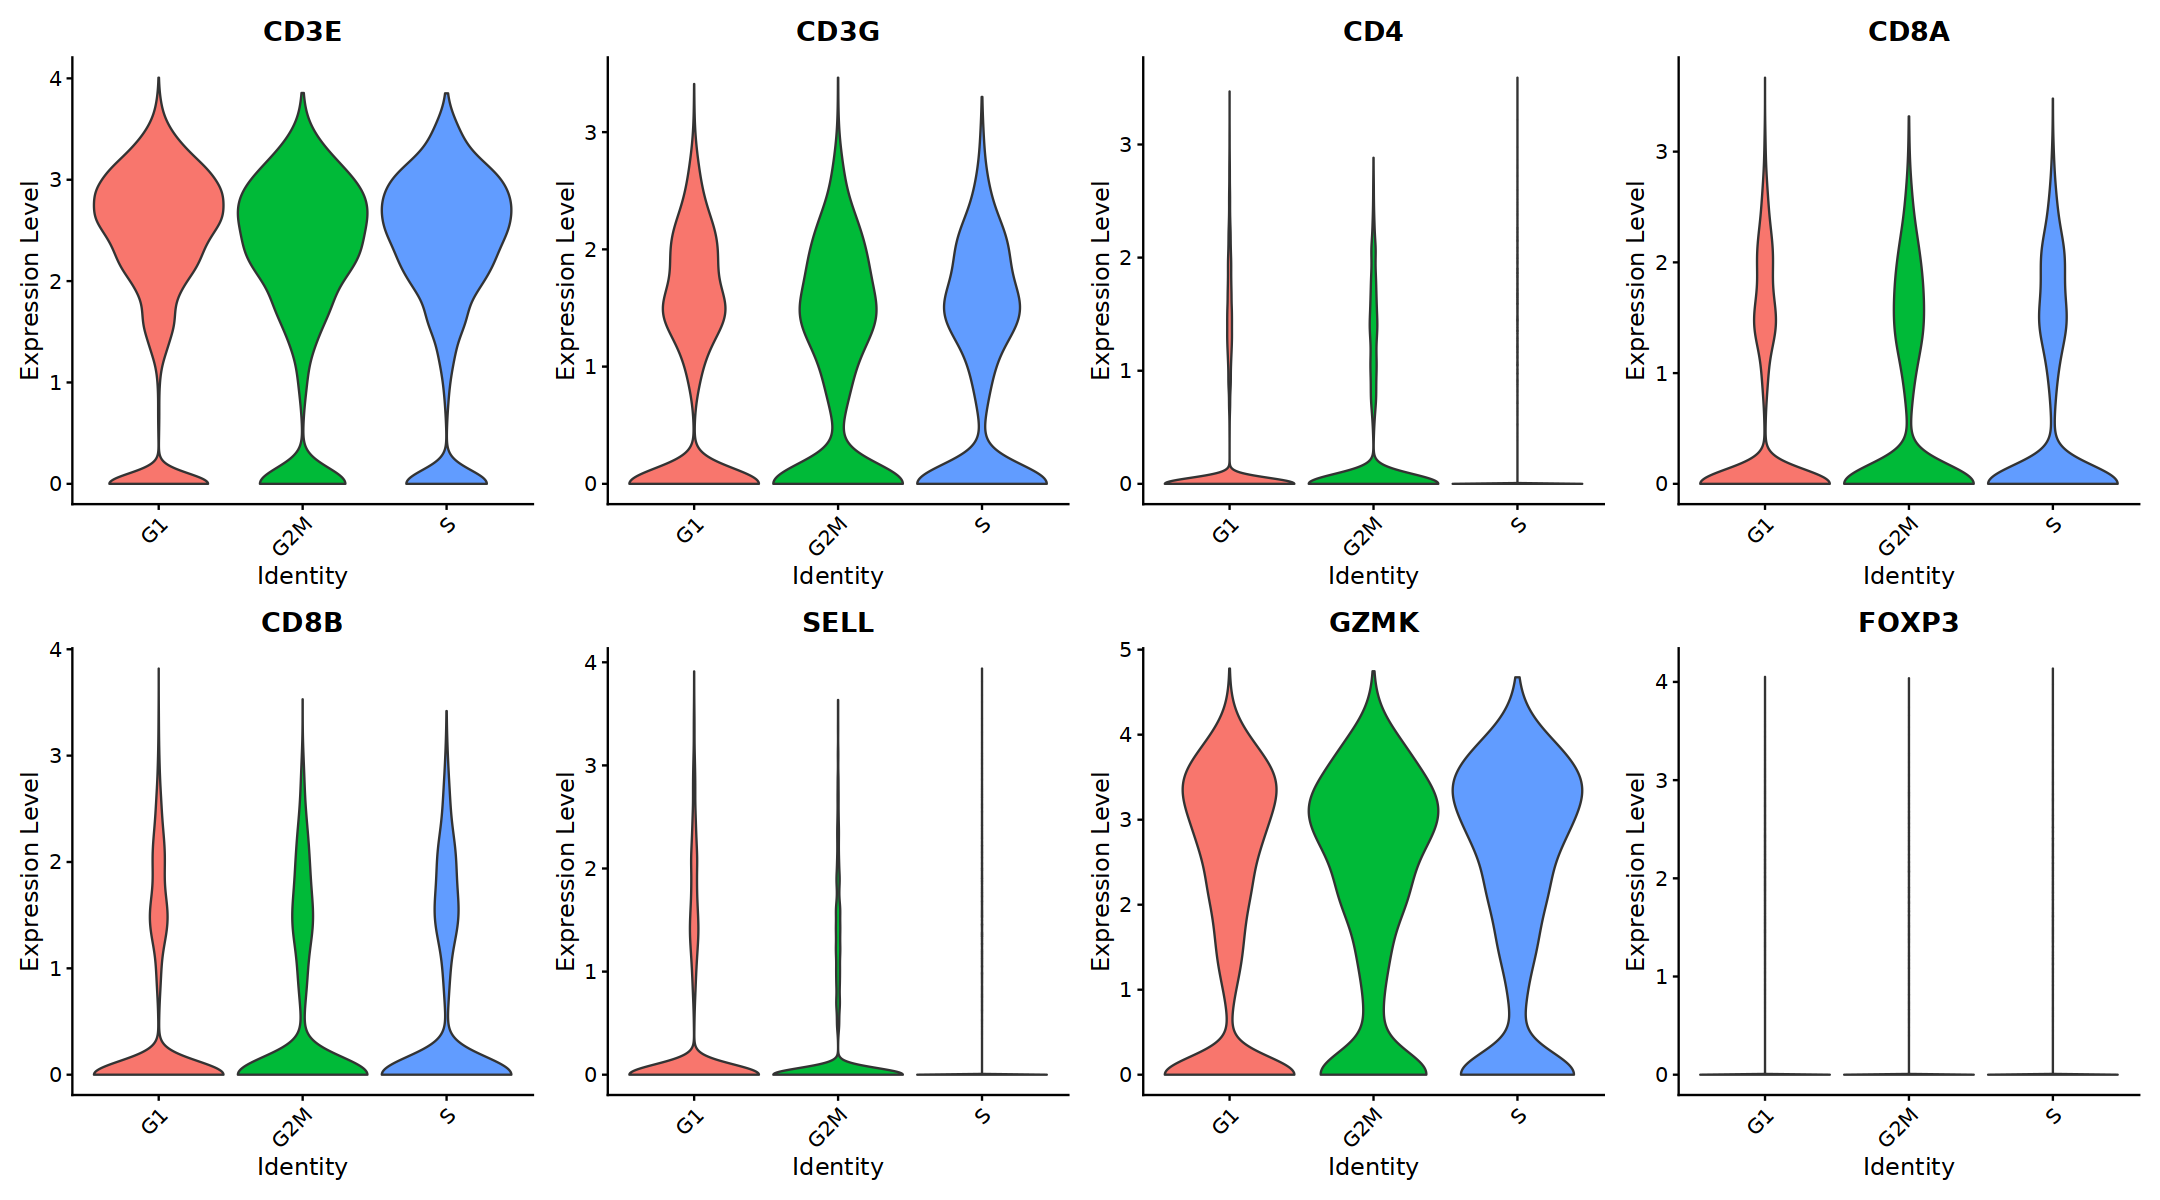

In [9]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj,features=markers, ncol=4, pt.size = 0)

In [10]:
reso = 0.2

In [11]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14043
Number of edges: 467763

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9304
Number of communities: 11
Elapsed time: 2 seconds


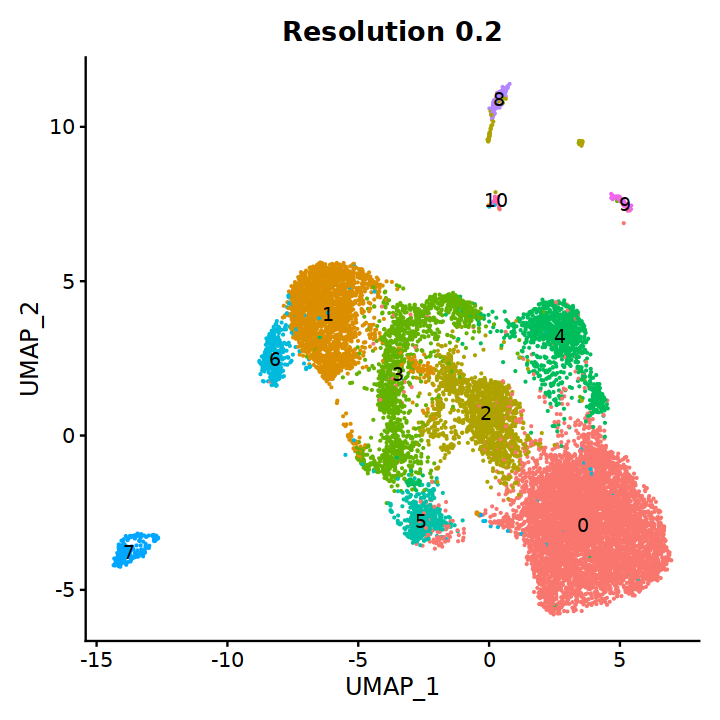

In [12]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

In [13]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



These looks like low quality cells

In [14]:
c <- 2
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
CHST11  4.252008e-123 2.061435   0.815 0.600 1.234953e-118 2       CHST11 
PIP4K2A 1.264277e-110 2.007984   0.765 0.522 3.671967e-106 2       PIP4K2A
ATXN1   1.109088e-157 1.909689   0.877 0.704 3.221236e-153 2       ATXN1  
SFMBT2   2.534983e-87 1.906539   0.685 0.420  7.362604e-83 2       SFMBT2 
PTPRJ    1.153257e-81 1.879067   0.675 0.456  3.349519e-77 2       PTPRJ  
PAG1     4.794310e-70 1.739693   0.614 0.373  1.392459e-65 2       PAG1

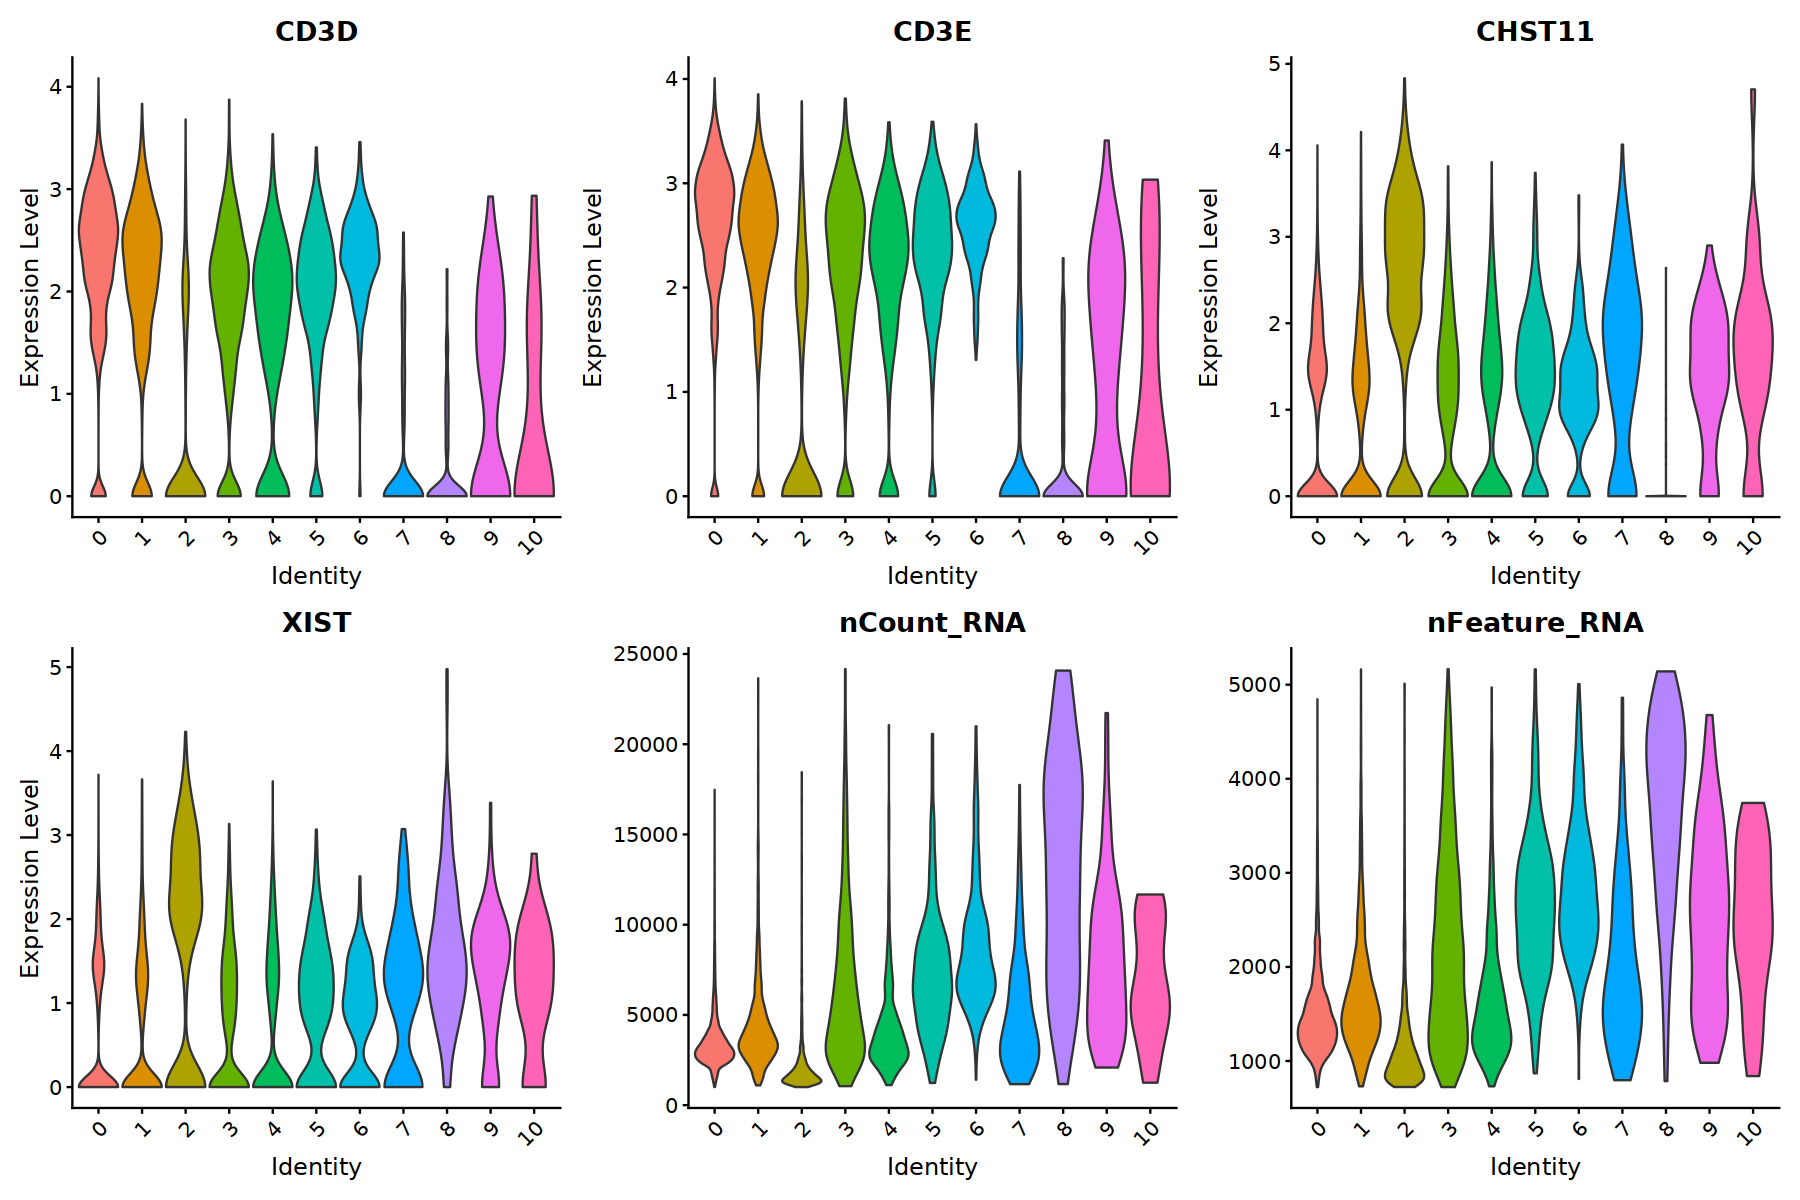

In [15]:
options(repr.plot.width = 15, repr.plot.height = 10, warn=-1,verbose = FALSE)

var = c("CD3D", "CD3E","CHST11", "XIST", 
        "nCount_RNA", "nFeature_RNA")
# show plots
VlnPlot(seurat_obj,features=var, ncol=3, pt.size = 0)

These seems like doublets (double positive Tregs??)

In [16]:
c <- 6
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj    cluster gene   
FOXP31   1.423986e-102 1.2360011  0.862 0.172 4.135824e-98 6       FOXP3  
IL2RA1    4.646130e-74 1.1233410  0.626 0.127 1.349422e-69 6       IL2RA  
BATF1     2.712007e-71 1.0280303  0.979 0.481 7.876753e-67 6       BATF   
IL12RB22  3.680115e-69 0.8596412  0.769 0.184 1.068853e-64 6       IL12RB2
LTB1      3.826053e-50 0.8305916  0.979 0.582 1.111239e-45 6       LTB    
IL322     2.257497e-59 0.7820209  1.000 0.918 6.556673e-55 6       IL32

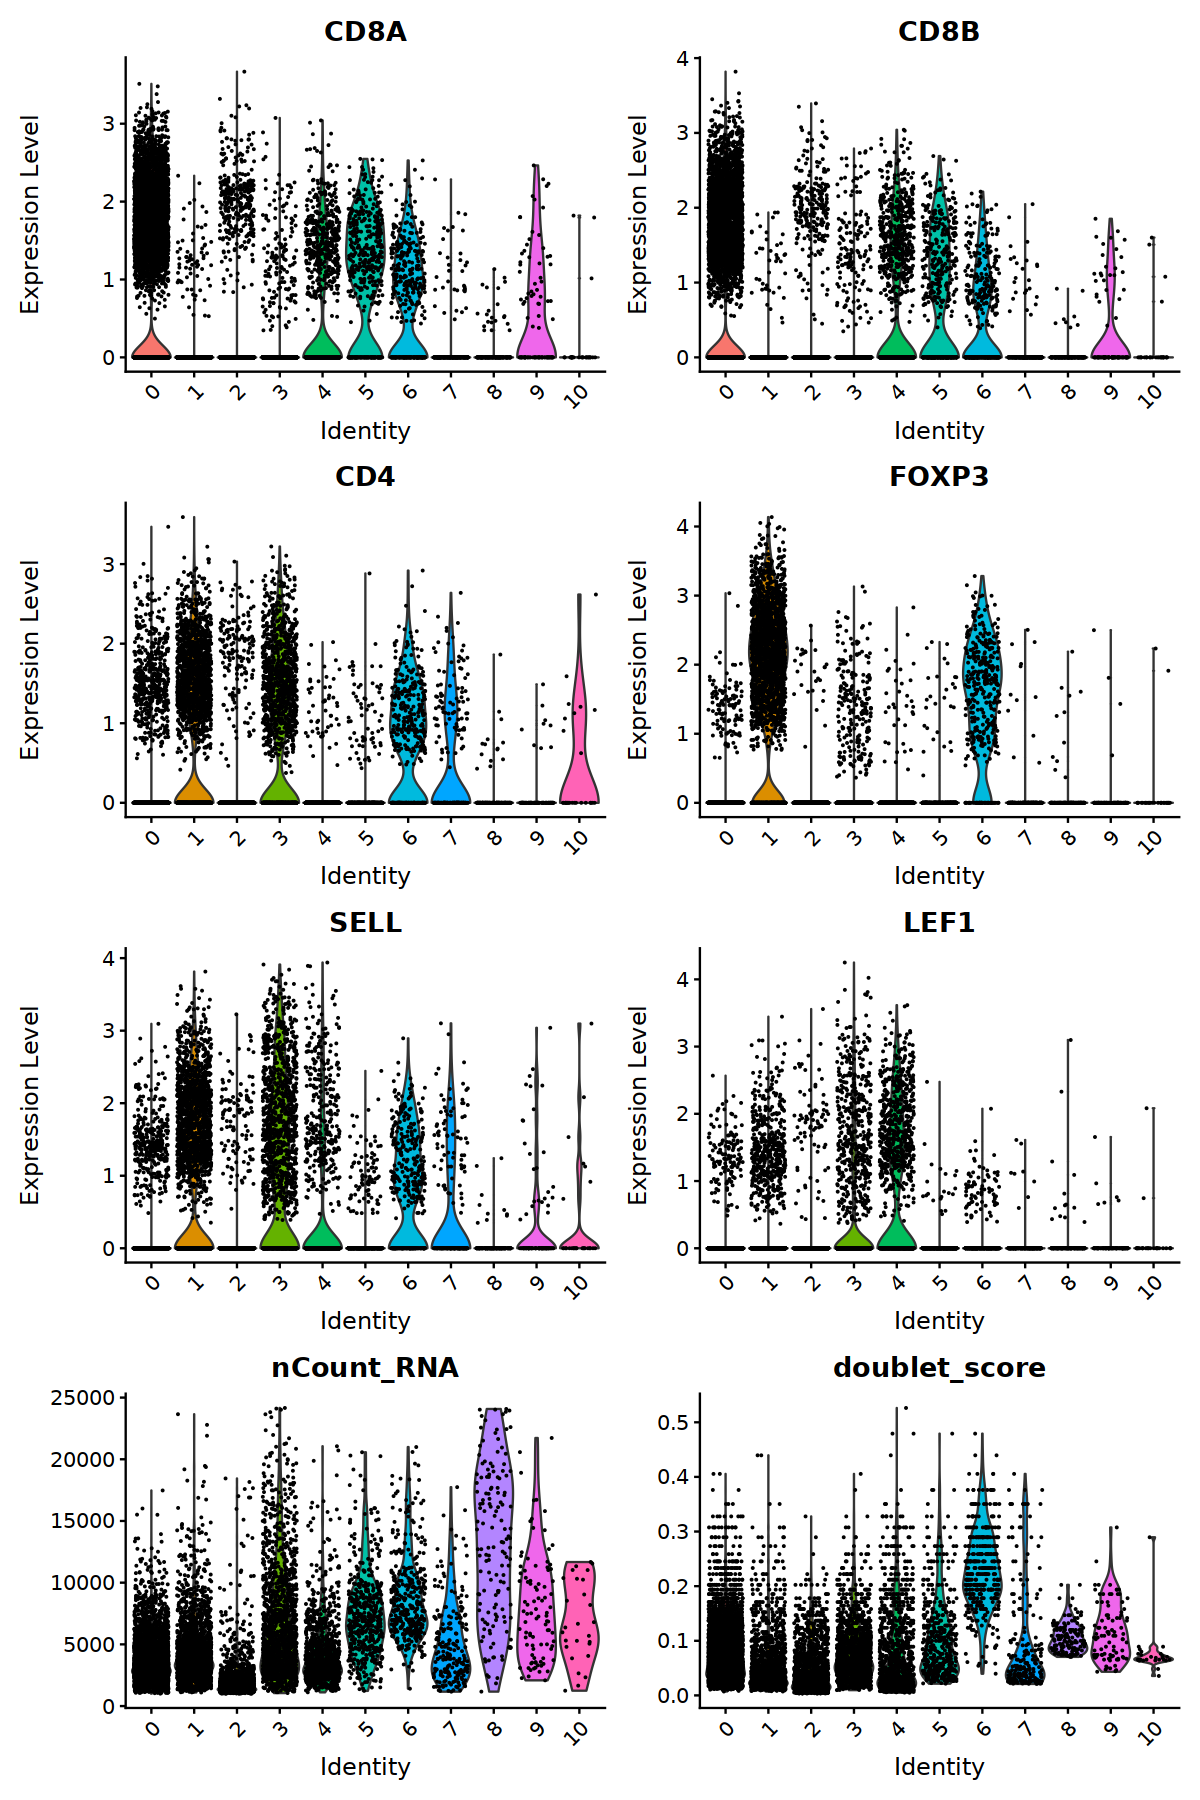

In [17]:
options(repr.plot.width = 10, repr.plot.height =15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=c("CD8A", "CD8B", "CD4", "FOXP3", 
                              "SELL", "LEF1",
                              "nCount_RNA", "doublet_score"), ncol=2)

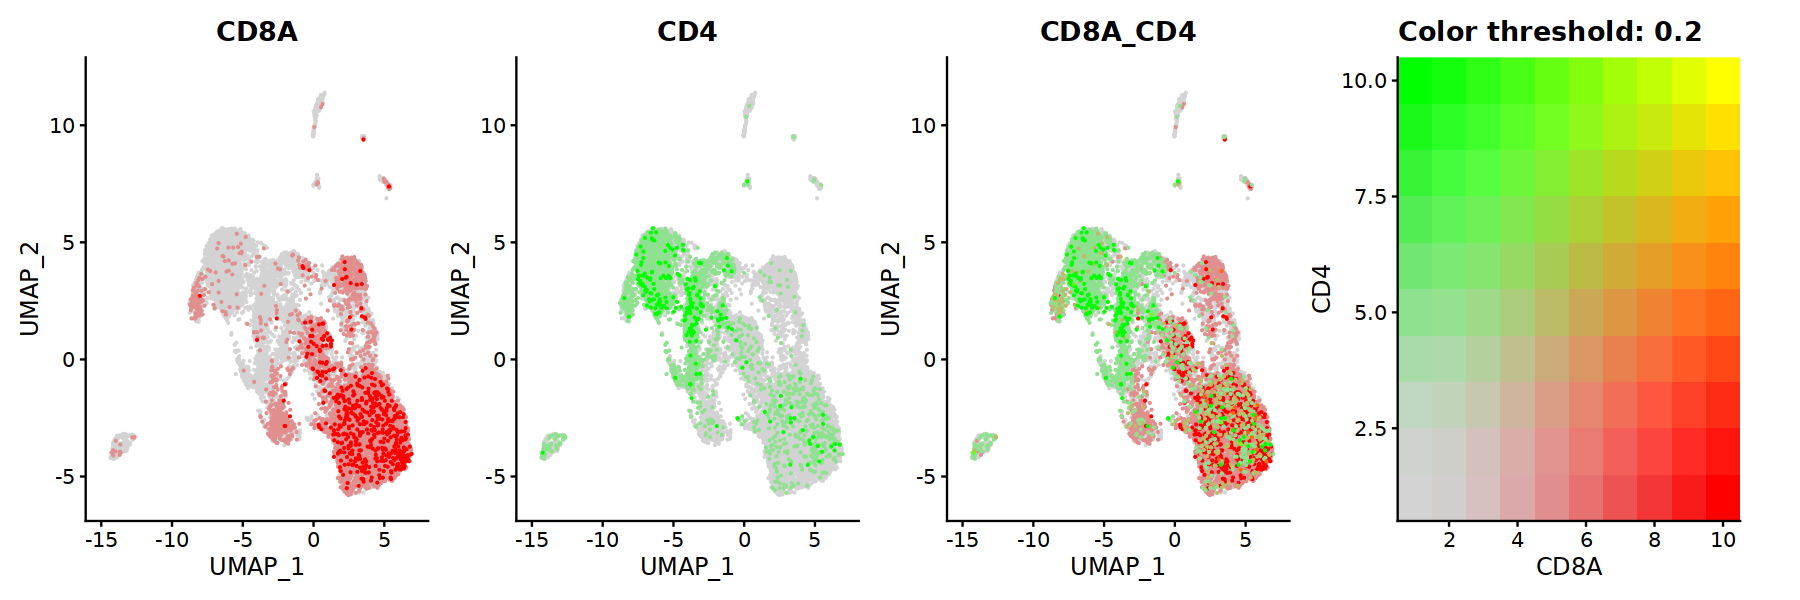

In [18]:
options(repr.plot.width = 15, repr.plot.height = 5, warn=-1,verbose = FALSE)

# show plots
FeaturePlot(seurat_obj, reduction = "umap", feature=c("CD8A", "CD4"),
            order = TRUE, blend = T,blend.threshold=0.2)

These looks like monocytes

In [19]:
c <- 7
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene  
S100A8  1.189778e-172 6.106939   0.726 0.011 3.455592e-168 7       S100A8
S100A9  9.024079e-169 5.890398   0.835 0.040 2.620954e-164 7       S100A9
VCAN    2.630373e-212 4.754622   0.882 0.012 7.639655e-208 7       VCAN  
LYZ     2.488798e-208 4.492822   0.840 0.008 7.228465e-204 7       LYZ   
TYROBP1 3.839204e-191 4.242688   0.877 0.039 1.115058e-186 7       TYROBP
IFI30   1.700332e-165 4.134294   0.910 0.094 4.938445e-161 7       IFI30

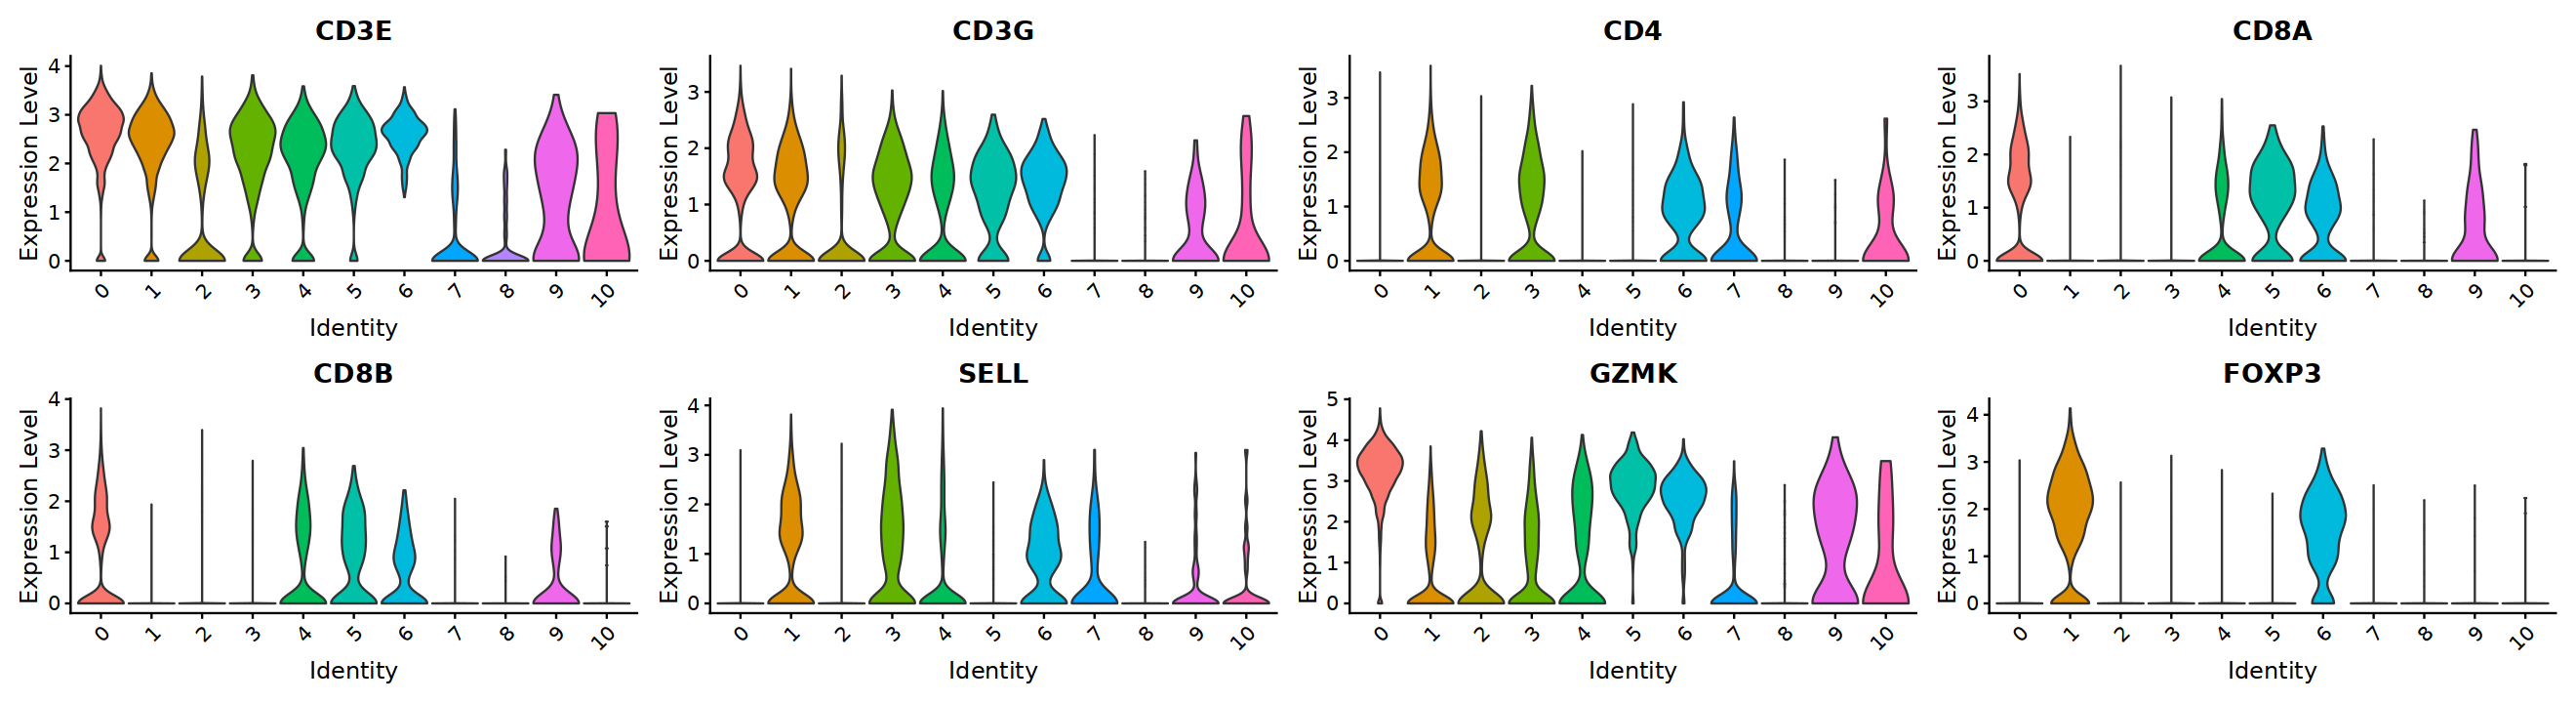

In [20]:
options(repr.plot.width = 22, repr.plot.height = 6, warn=-1,verbose = FALSE)

var = c("PTPRC", "S100A8", "S100A9", "VCAN")
# show plots
VlnPlot(seurat_obj,features=markers, ncol=4, pt.size = 0)

These looks like tumor cells or fibroblast

In [21]:
c <- 8
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
COL1A2  1.596585e-208 4.896608   0.959 0.023 4.637121e-204 8       COL1A2 
MEG3    1.710791e-214 4.081939   0.918 0.010 4.968821e-210 8       MEG3   
CNTNAP2 1.555145e-179 4.046822   0.801 0.007 4.516762e-175 8       CNTNAP2
AUTS21  4.830054e-168 3.972543   0.986 0.075 1.402841e-163 8       AUTS2  
COL3A1  1.426959e-176 3.964227   0.842 0.019 4.144460e-172 8       COL3A1 
ROBO1   2.394549e-196 3.729483   0.849 0.009 6.954729e-192 8       ROBO1

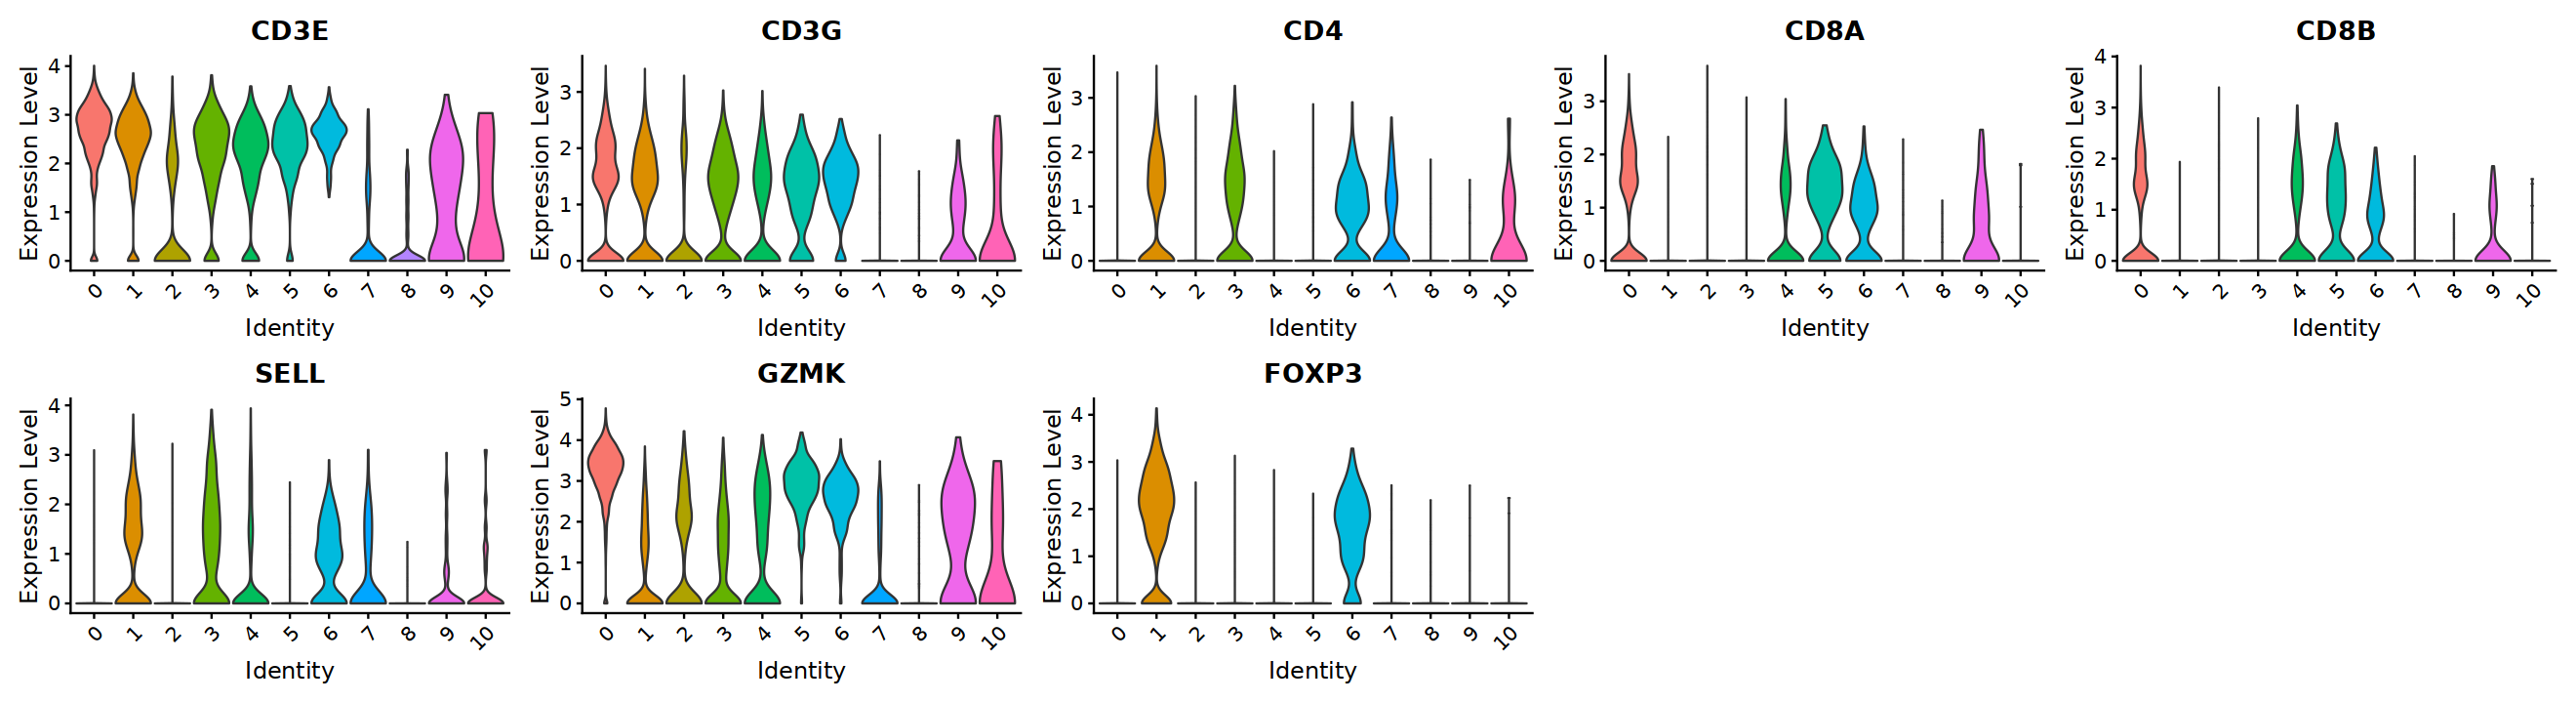

In [22]:
options(repr.plot.width = 22, repr.plot.height = 6, warn=-1,verbose = FALSE)

var = c("PTPRC", "COL1A2", "IGHM", "PCDH9", "S100A8")
# show plots
VlnPlot(seurat_obj,features=markers, ncol=5, pt.size = 0)

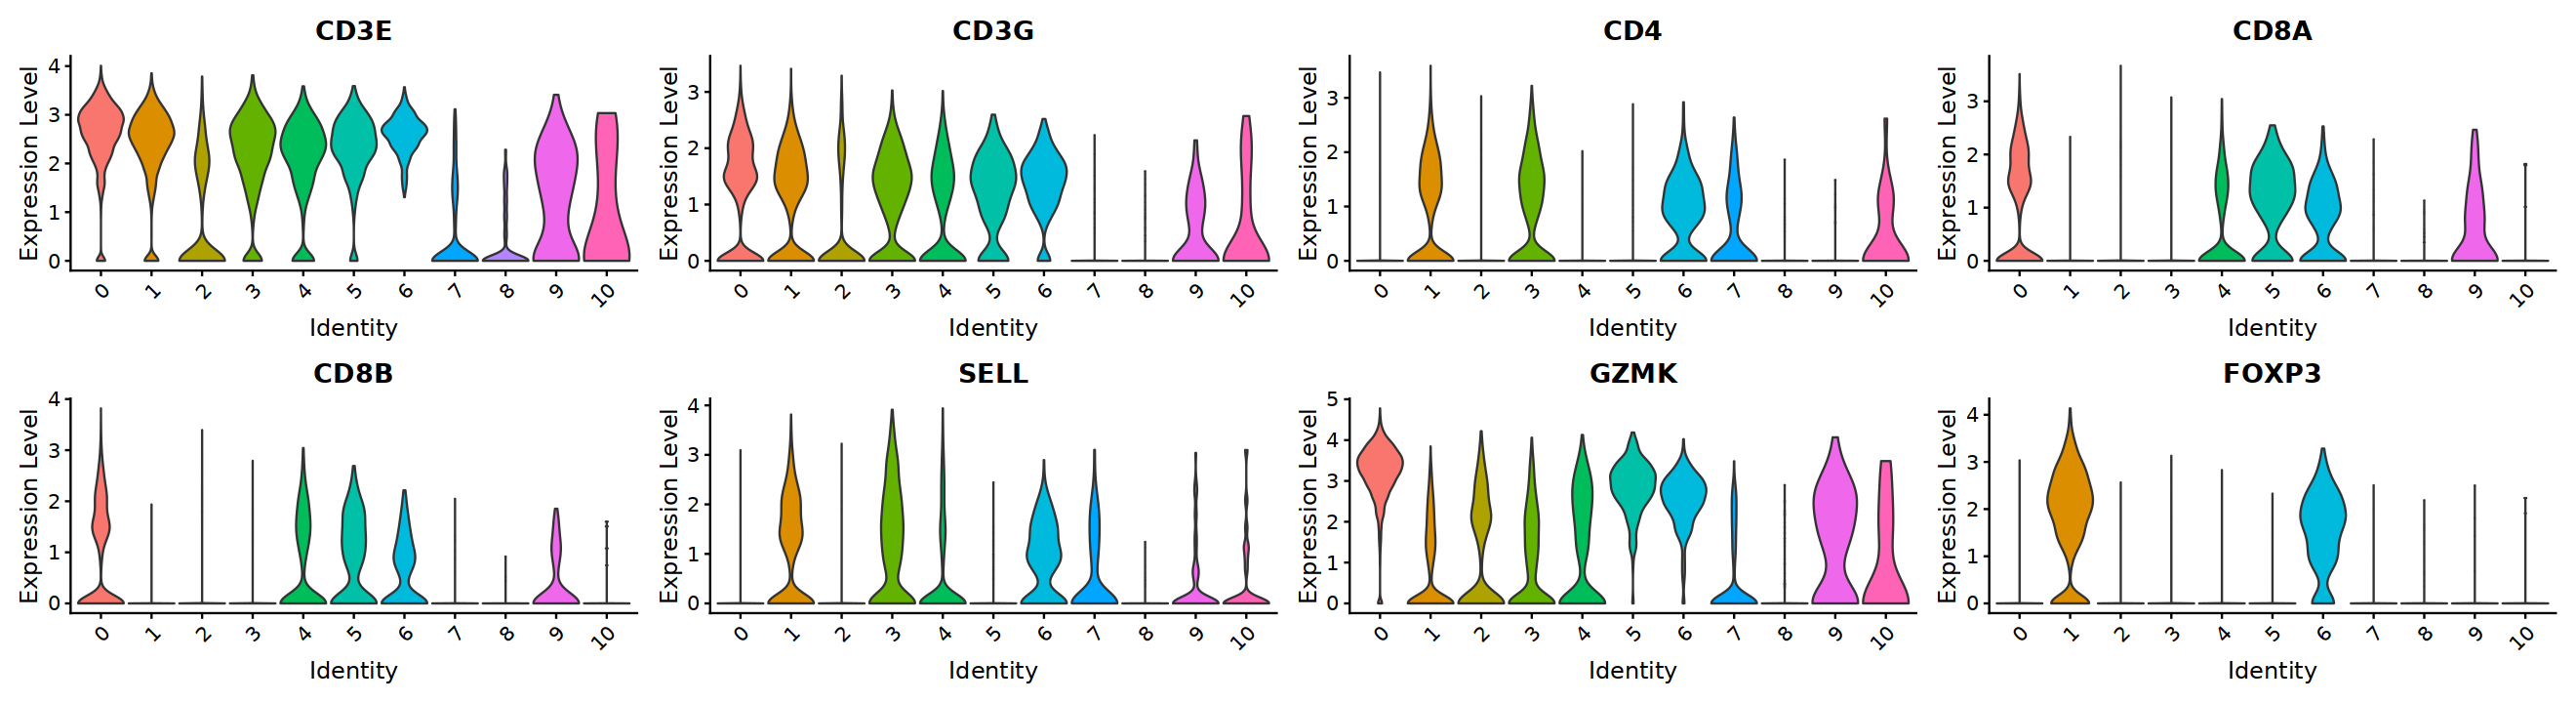

In [23]:
options(repr.plot.width = 22, repr.plot.height = 6, warn=-1,verbose = FALSE)

var = c("PTPRC", "SPARC", "FN1", "COL3A1")
# show plots
VlnPlot(seurat_obj,features=markers, ncol=4, pt.size = 0)

Plasma Cells

In [24]:
c <- 9
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
IGHM    2.353523e-116 8.121633   0.763 0.037 6.835572e-112 9       IGHM   
IGLC2   8.792096e-111 7.040635   0.559 0.009 2.553576e-106 9       IGLC2  
IGHG1    2.743598e-61 6.575845   0.333 0.007  7.968505e-57 9       IGHG1  
IGLC1   8.711802e-140 6.322595   0.624 0.003 2.530256e-135 9       IGLC1  
IGKC    7.145515e-109 6.085552   0.548 0.012 2.075343e-104 9       IGKC   
IGKV4-1  6.215953e-38 5.902681   0.204 0.007  1.805362e-33 9       IGKV4-1

Mast cells and DC

In [25]:
c <- 10
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
CPA3    1.295809e-154 5.917100   0.926 0.006 3.763547e-150 10      CPA3   
KIT     3.730983e-177 5.484152   0.963 0.004 1.083627e-172 10      KIT    
HPGD2    3.318503e-56 4.765695   0.926 0.060  9.638260e-52 10      HPGD   
SLC24A3 1.135180e-184 4.634497   0.889 0.002 3.297018e-180 10      SLC24A3
TPSD1   1.451078e-201 4.363395   0.963 0.001 4.214512e-197 10      TPSD1  
HDC     4.220279e-154 4.236521   0.926 0.011 1.225738e-149 10      HDC    
TPSB2   4.950765e-193 4.130661   0.926 0.003 1.437900e-188 10      TPSB2  
MS4A2   3.616856e-159 3.546332   0.778 0.001 1.050480e-154 10      MS4A2  
HPGDS   1.573411e-169 3.461902   0.852 0.002 4.569814e-165 10      HPGDS  
RHEX1   4.540731e-180 3.298133   0.926 0.003 1.318810e-175 10      RHEX   
GALC     9.756942e-75 3.286889   0.815 0.039  2.833806e-70 10      GALC   
TPSAB1  1.107657e-166 3.285090   0.778 0.002 3.217078e-162 10      TPSAB1 
LRMDA1  1.205529e-115 3.182944   0.815 0.014 3.501339e-111 10      LRMDA  
GLUL1    1.200164e-46 3.162318   0.815 0.065  3.485756e-42 10      GLUL   
IL1RL12  1.425184e-39 3.147152   0.741 0.077  4.139305e-35 10      IL1RL1

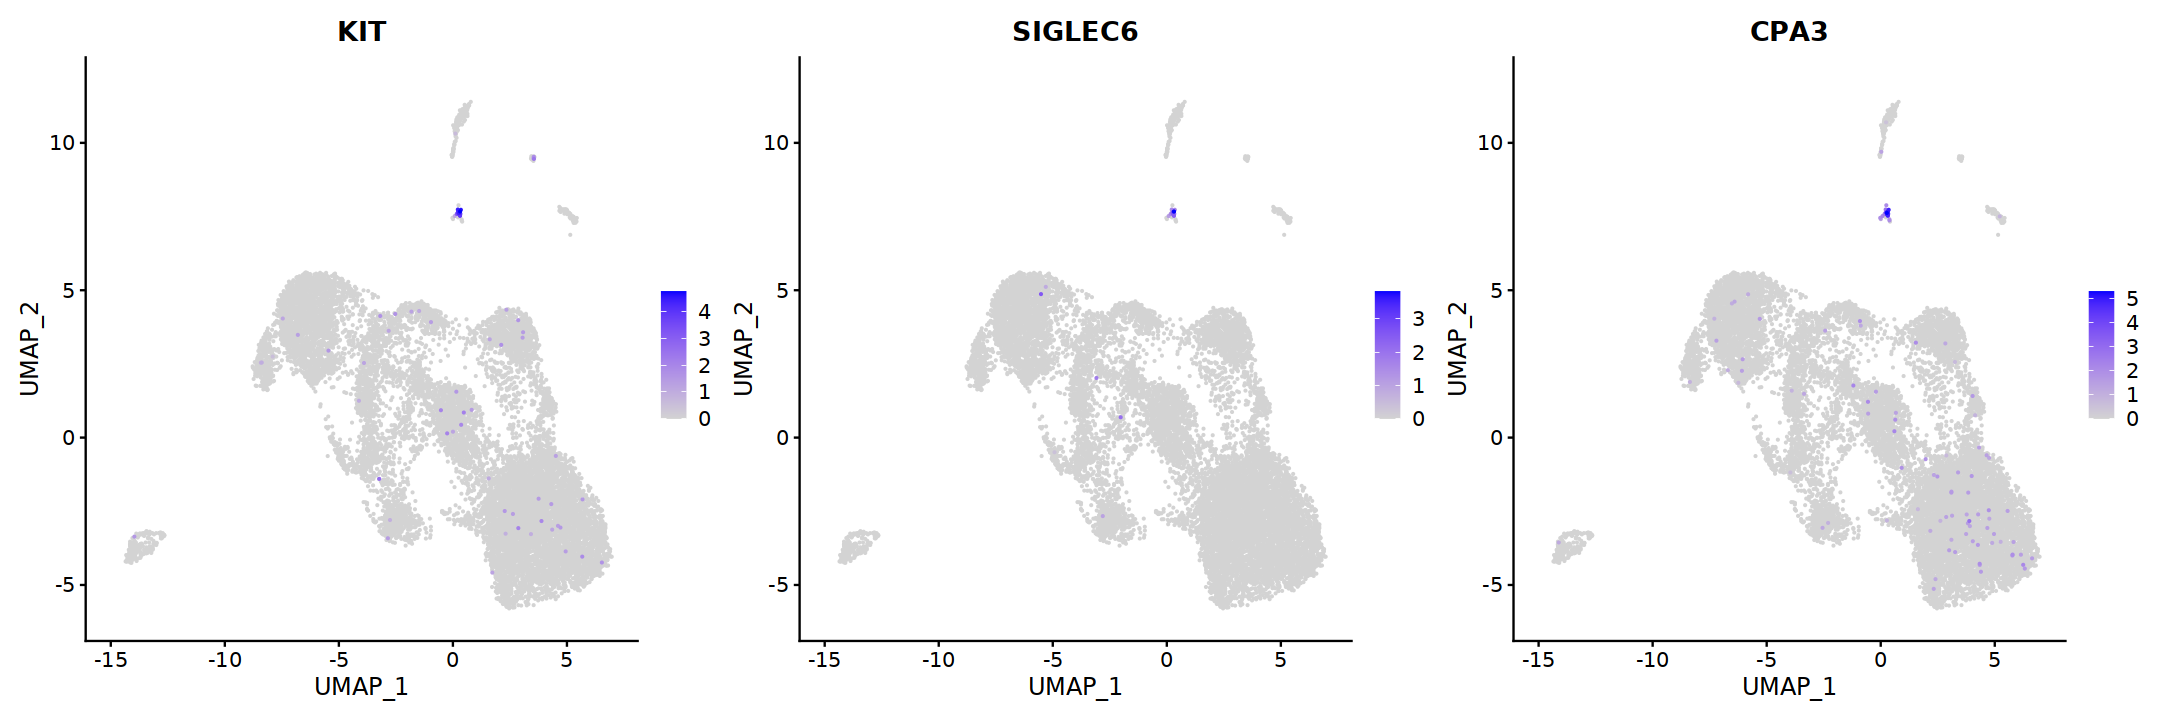

In [26]:
options(repr.plot.width = 18, repr.plot.height = 6, warn=-1,verbose = FALSE)

var = c("KIT", "SIGLEC6", "CPA3")
# show plots
FeaturePlot(seurat_obj, reduction = "umap", feature=var, 
            order = TRUE, ncol=3)

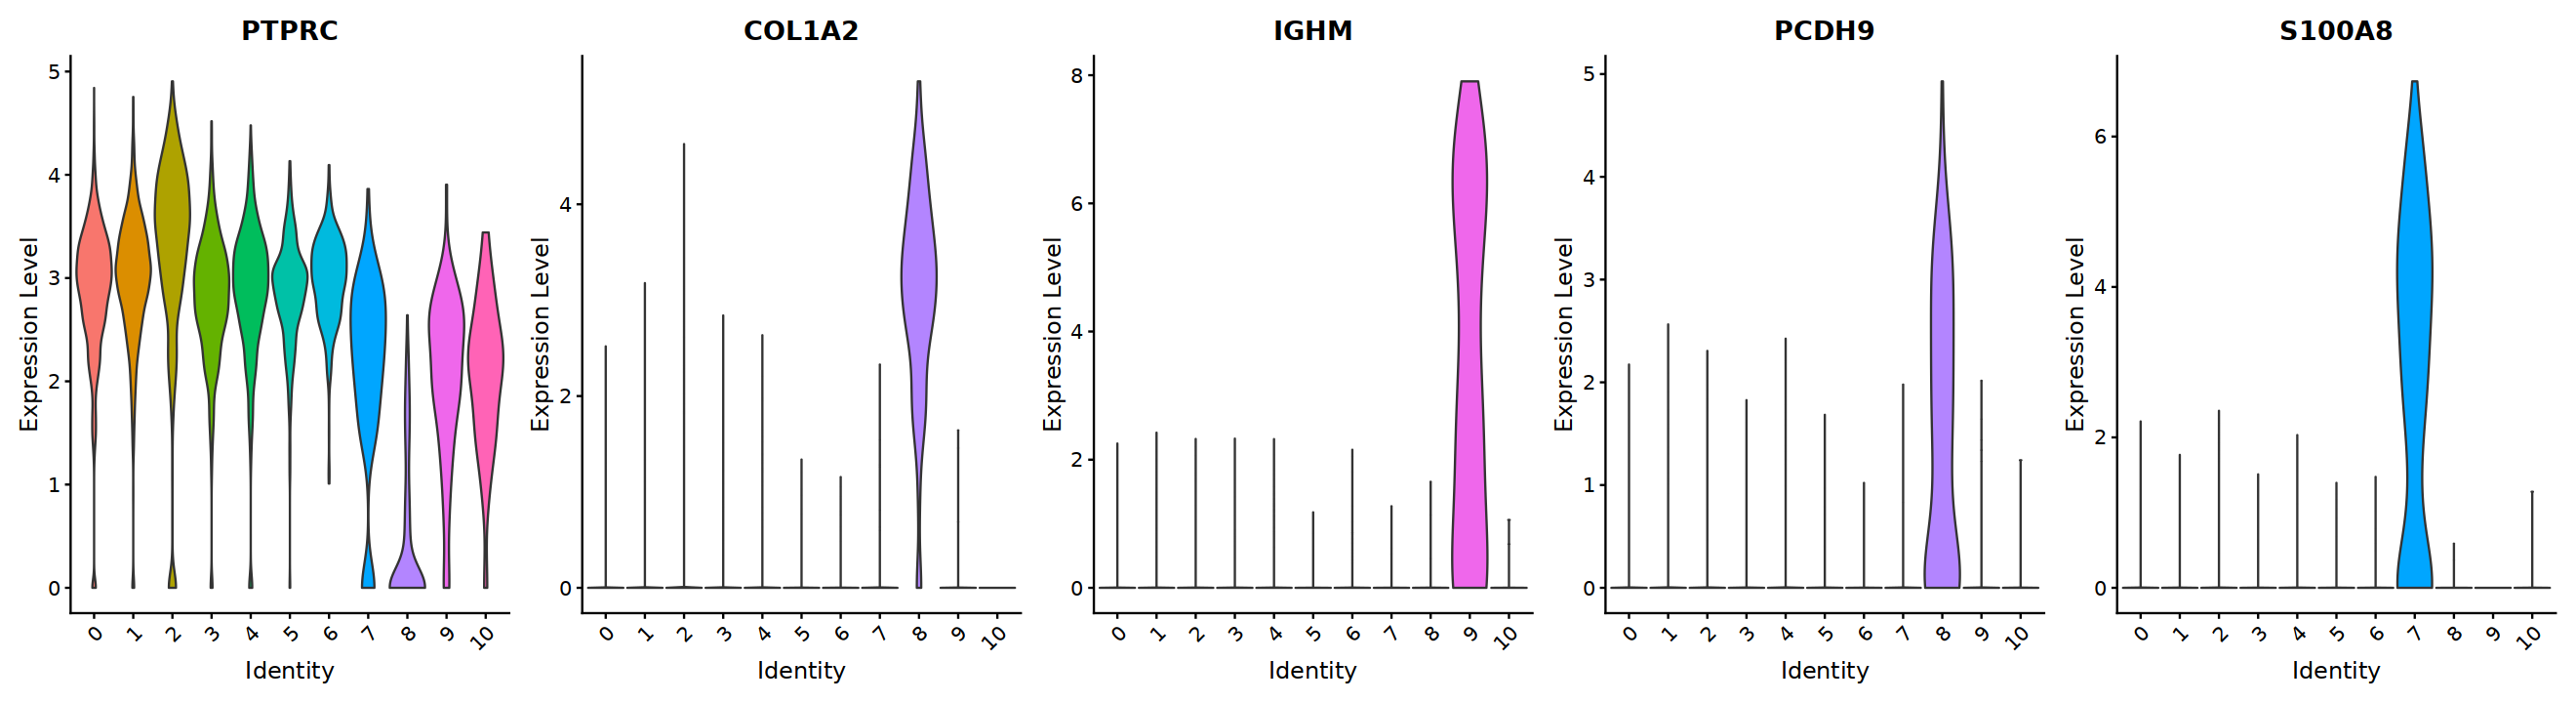

In [27]:
options(repr.plot.width = 22, repr.plot.height = 6, warn=-1,verbose = FALSE)

var = c("PTPRC", "COL1A2", "IGHM", "PCDH9", "S100A8")
# show plots
VlnPlot(seurat_obj,features=var, ncol=5, pt.size = 0)

### Remove cells 

Remove cells that have low CD45 expression that actually look like other cell types

In [28]:
seurat_obj <- subset(x=seurat_obj, idents=c(2,6,7,8,9,10), invert=TRUE)

In [29]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
26058  2986 


An object of class Seurat 
26058 features across 11637 samples within 1 assay 
Active assay: RNA (26058 features, 692 variable features)
 2 dimensional reductions calculated: pca, umap

## Re-do embedding and clustering

In [30]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [31]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 26058 11637 
metadata(0):
assays(2): counts logcounts
rownames(26058): AL627309.1 AL627309.3 ... AC233755.2 AC007325.4
rowData names(0):
colnames(11637): AAACCTGAGCAGCCTC-1 AAACCTGAGCAGCGTA-1 ...
  TTTGTCATCGGAAATA-1 TTTGTCATCGGAGCAA-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(2): PCA UMAP
mainExpName: RNA
altExpNames(0):

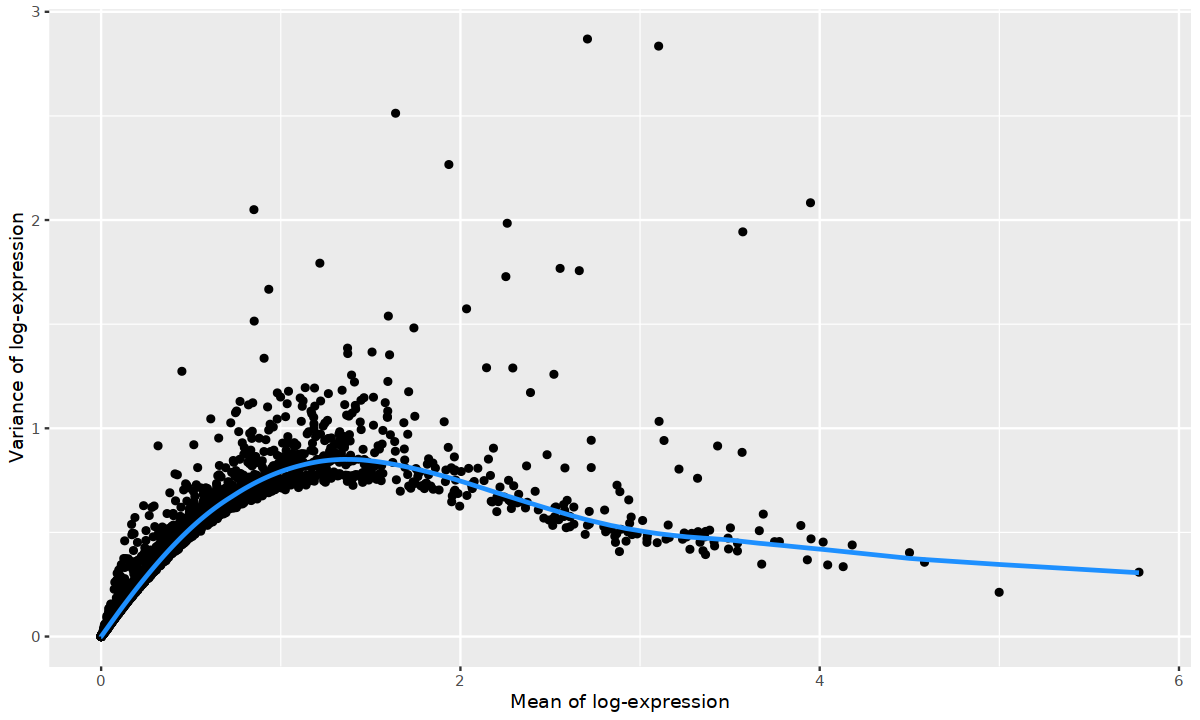

In [32]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)
gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")

In [33]:
gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

mean      total    tech      bio       p.value       FDR          
NKG7   2.7071902 2.869307 0.5599473 2.3093601  0.000000e+00  0.000000e+00
CCL5   3.1034441 2.835156 0.4939275 2.3412287  0.000000e+00  0.000000e+00
CCL4   1.6391055 2.512829 0.8254847 1.6873442  4.875399e-79  1.588039e-75
FOS    1.9356909 2.266564 0.7632570 1.5033073  1.536305e-73  4.448115e-70
HSPA1A 3.9487525 2.082964 0.4238561 1.6591084 1.012851e-283 8.797625e-280
HSPA6  0.8504940 2.049858 0.7350010 1.3148574  4.827906e-61  8.387038e-58
GZMK   2.2605981 1.984633 0.6748843 1.3097485  1.841908e-71  3.999703e-68
HSPA1B 3.5719714 1.943263 0.4565158 1.4867468 3.810220e-197 2.482168e-193
GZMB   1.2175667 1.792833 0.8409624 0.9518706  1.203494e-25  5.501869e-23
JUN    2.5549500 1.767778 0.5970149 1.1707627  6.398029e-73  1.667198e-69
DNAJB1 2.6616733 1.756907 0.5706943 1.1862124  1.184766e-81  4.410375e-78
GZMA   2.2529967 1.728218 0.6769327 1.0512856  1.604651e-46  1.493357e-43
CCL3   0.9331930 1.667485 0.7692807 0.8982047  3.640154e-27  1.756577e-24
CD69   2.0342444 1.573660 0.7374088 0.8362515  9.770857e-26  4.546589e-23
CTSW   1.5987242 1.538768 0.8317334 0.7070343  2.796785e-15  7.158363e-13
IL7R   0.8520736 1.514681 0.7357185 0.7789625  1.112663e-22  4.460579e-20
SAT1   1.7410992 1.481885 0.8069477 0.6749369  7.520118e-15  1.848672e-12
LTB    1.3717353 1.385040 0.8505464 0.5344935  3.834837e-09  4.461080e-07
ZFP36  1.5080951 1.366171 0.8431242 0.5230466  5.933581e-09  6.751845e-07
PRF1   1.3727917 1.358874 0.8505514 0.5083228  1.978756e-08  2.036116e-06

In [34]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 1115

In [35]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 1009

In [36]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  FOXP3, IL12RB2, SELL, IL7R, TIMP1, IL2RA, BATF, KLRB1, CCR8, LTB 
	   RTKN2, IL32, ICOS, AL136456.1, IL1R2, S100A4, LEF1, TMSB10, TSC22D3, LINC02195 
	   SAT1, CTLA4, BACH2, SLC2A3, LINC02099, TCF7, DEPP1, PLAC8, TXNIP, CCR7 
Negative:  NKG7, CCL5, GZMK, CTSW, CCL4, PRF1, CST7, LYST, VCAM1, CCL4L2 
	   GZMA, KLRK1, FCGR3A, GZMB, GZMH, CCL3, KLRC4, AOAH, LINC01934, AL133405.2 
	   RGS2, IFNG, CD74, ID2, TNFRSF9, CRTAM, TNFSF4, HLA-DRB1, HLA-DRA, CCL3L1 
PC_ 2 
Positive:  HSPA1A, TXNIP, HSPA1B, TCF7, DNAJB1, LEF1, IL7R, ZNF683, PLAC8, TSPYL2 
	   JUN, AOAH, KLRC2, KLRD1, BACH2, KLRK1, AREG, LINC02446, CCR7, BTG2 
	   NR4A1, TAFA1, XCL1, HSPA8, TSC22D1, TSC22D3, HSPA6, HSP90AA1, CXCR4, XCL2 
Negative:  MKI67, RRM2, STMN1, TOP2A, HIST1H3C, HIST1H3B, CENPF, ASPM, HIST1H1B, TUBB 
	   HIST1H2AH, TUBA1B, HIST1H2AL, HIST1H4C, HMGB2, HIST1H3F, HIST1H1C, HIST1H1E, ACTB, GAPDH 
	   HIST1H1D, MT2A, ACTG1, GZMA, LGALS1, TMSB10, CTLA4, HLA-DRA, GZM

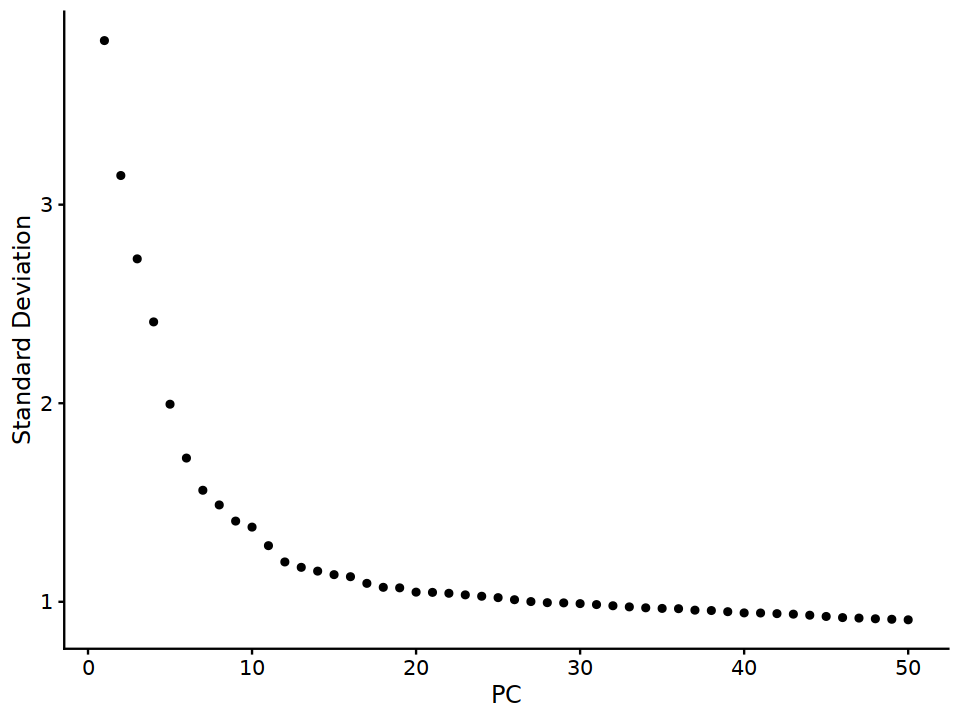

In [37]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [38]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:20,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

18:30:13 UMAP embedding parameters a = 0.9922 b = 1.112

18:30:13 Read 11637 rows and found 20 numeric columns

18:30:13 Using Annoy for neighbor search, n_neighbors = 30

18:30:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:30:14 Writing NN index file to temp file /scratch_tmp/33937378/Rtmp6e5ams/file3a05c791705c7

18:30:14 Searching Annoy index using 1 thread, search_k = 3000

18:30:17 Annoy recall = 100%

18:30:18 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:30:20 Initializing from normalized Laplacian + noise (using irlba)

18:30:20 Commencing optimization for 200 epochs, with 491870 positive edges

18:30:33 Optimization finished



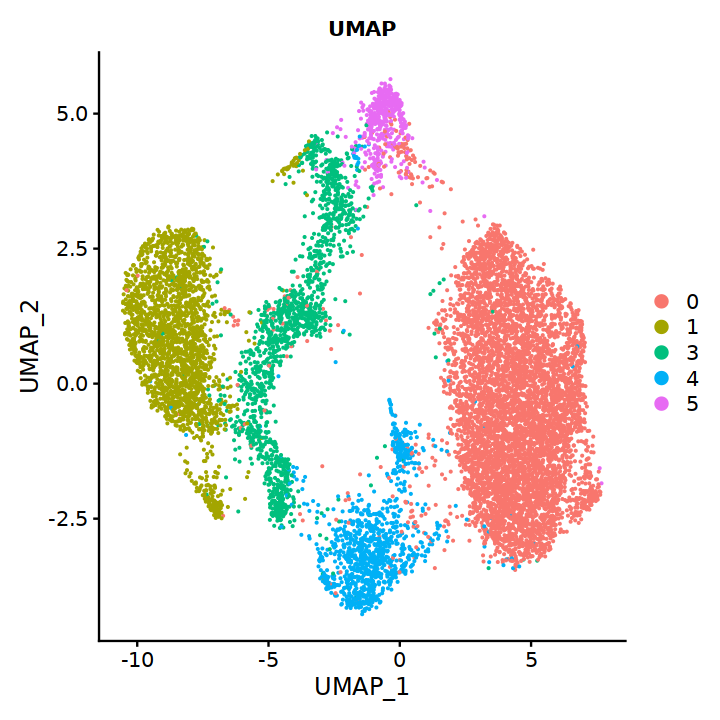

In [39]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle(glue('UMAP')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

In [40]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:20)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11637
Number of edges: 371655

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9543
Number of communities: 4
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11637
Number of edges: 371655

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9265
Number of communities: 6
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11637
Number of edges: 371655

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8999
Number of communities: 6
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11637
Number of edges: 371655

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8738
Number of communities: 8
Elapsed time: 1 seconds
Modularity Optim

In [41]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

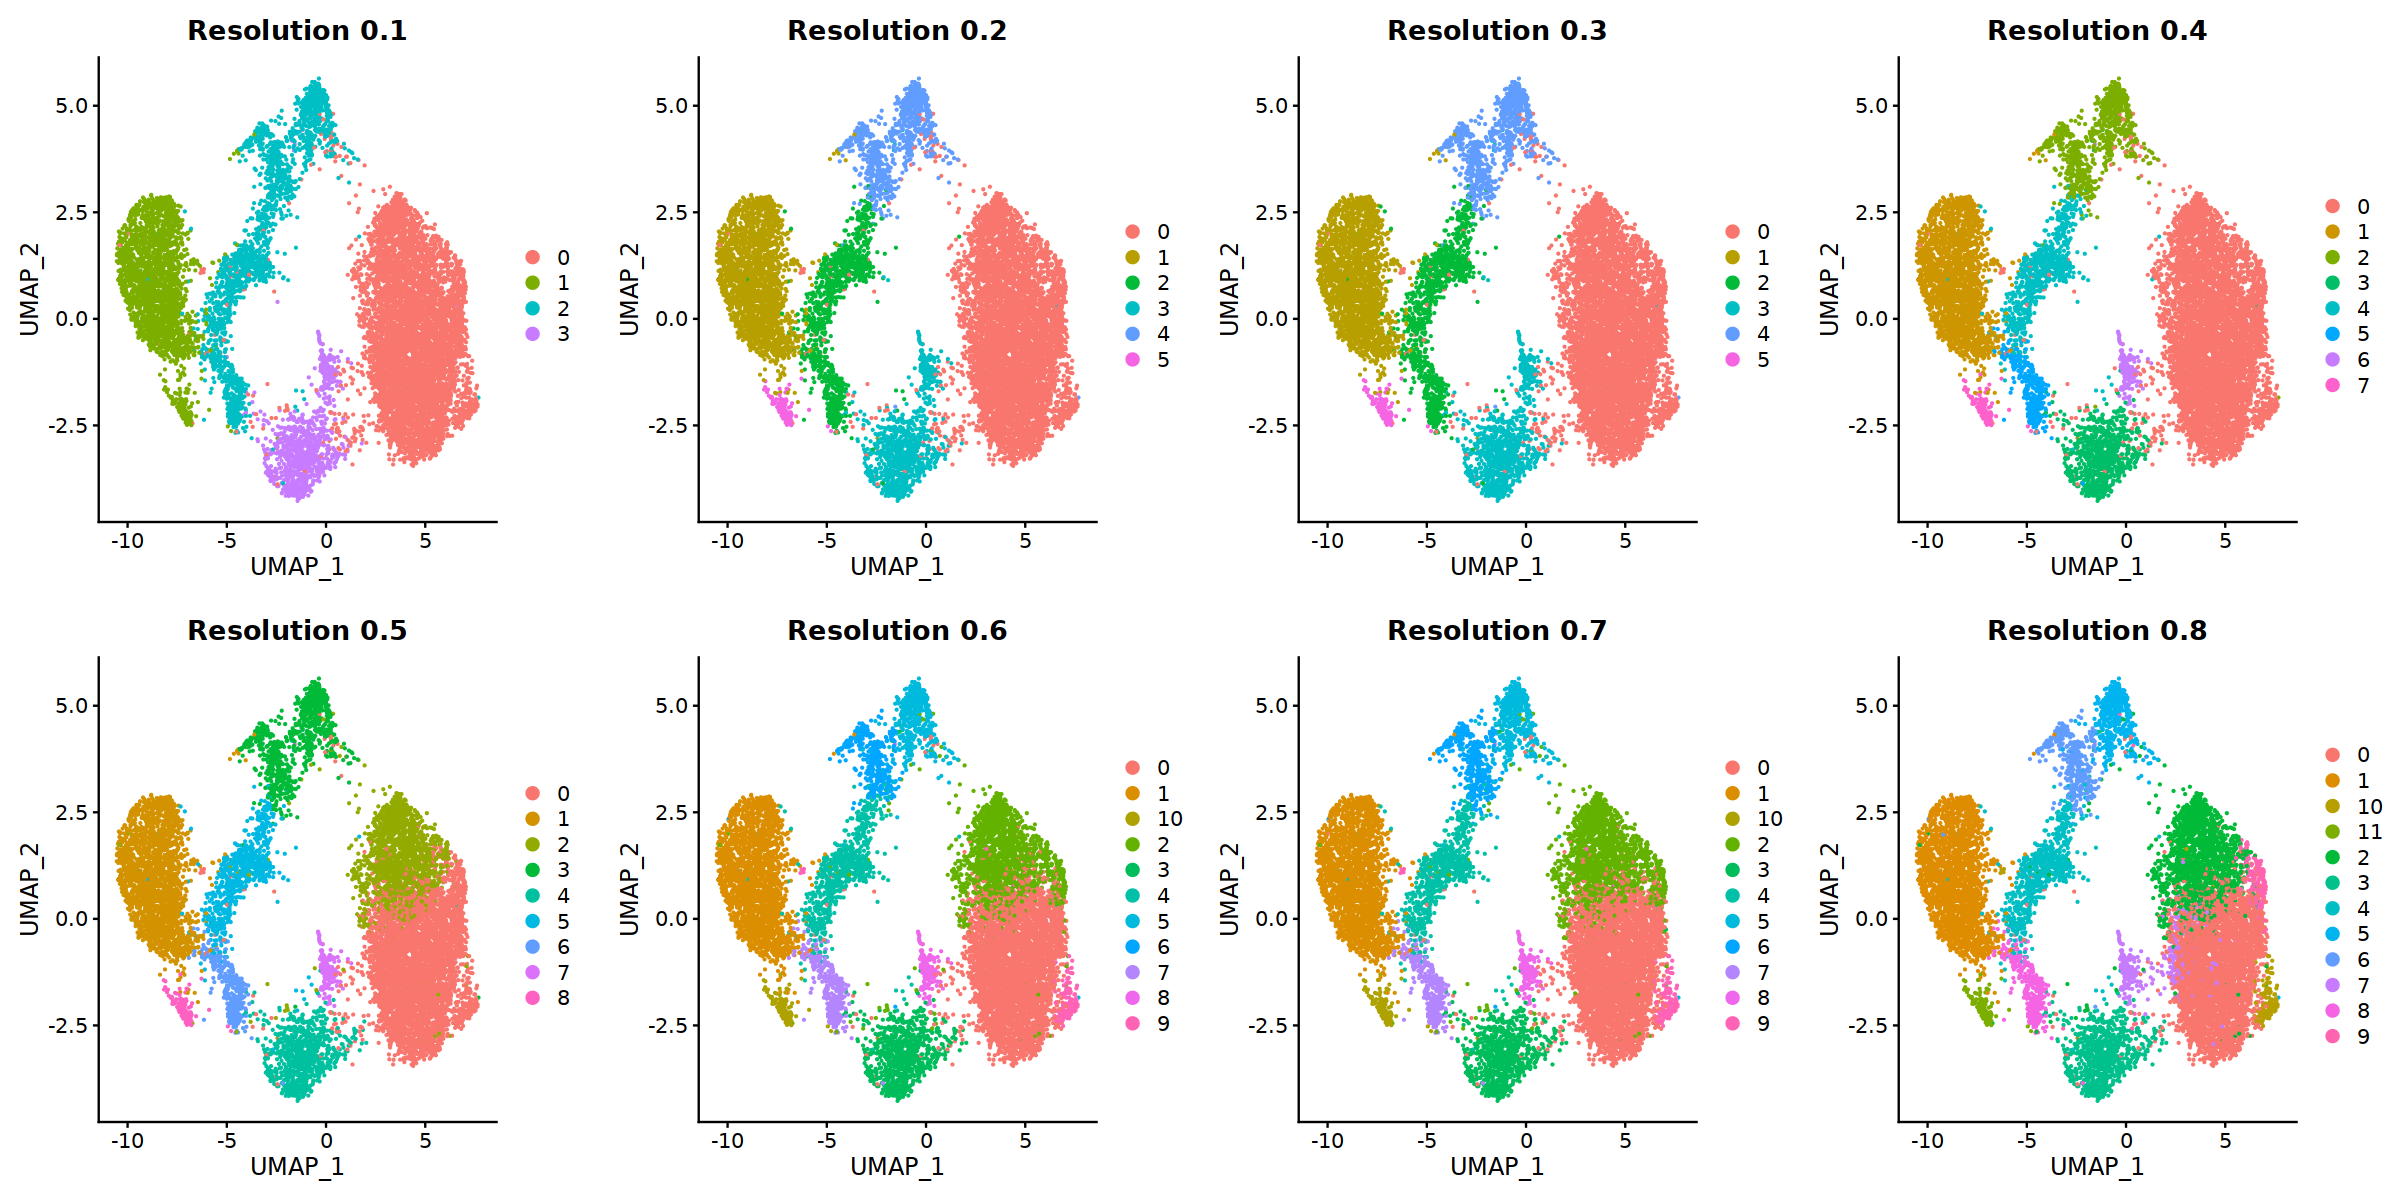

In [42]:
options(repr.plot.width = 20, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [43]:
reso = 0.2

In [44]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11637
Number of edges: 371655

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9265
Number of communities: 6
Elapsed time: 1 seconds


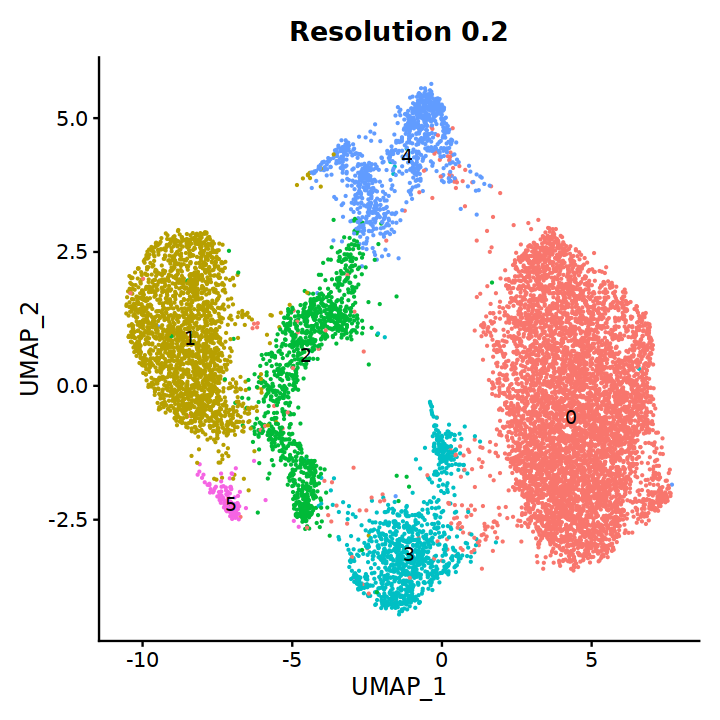

In [45]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

In [46]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



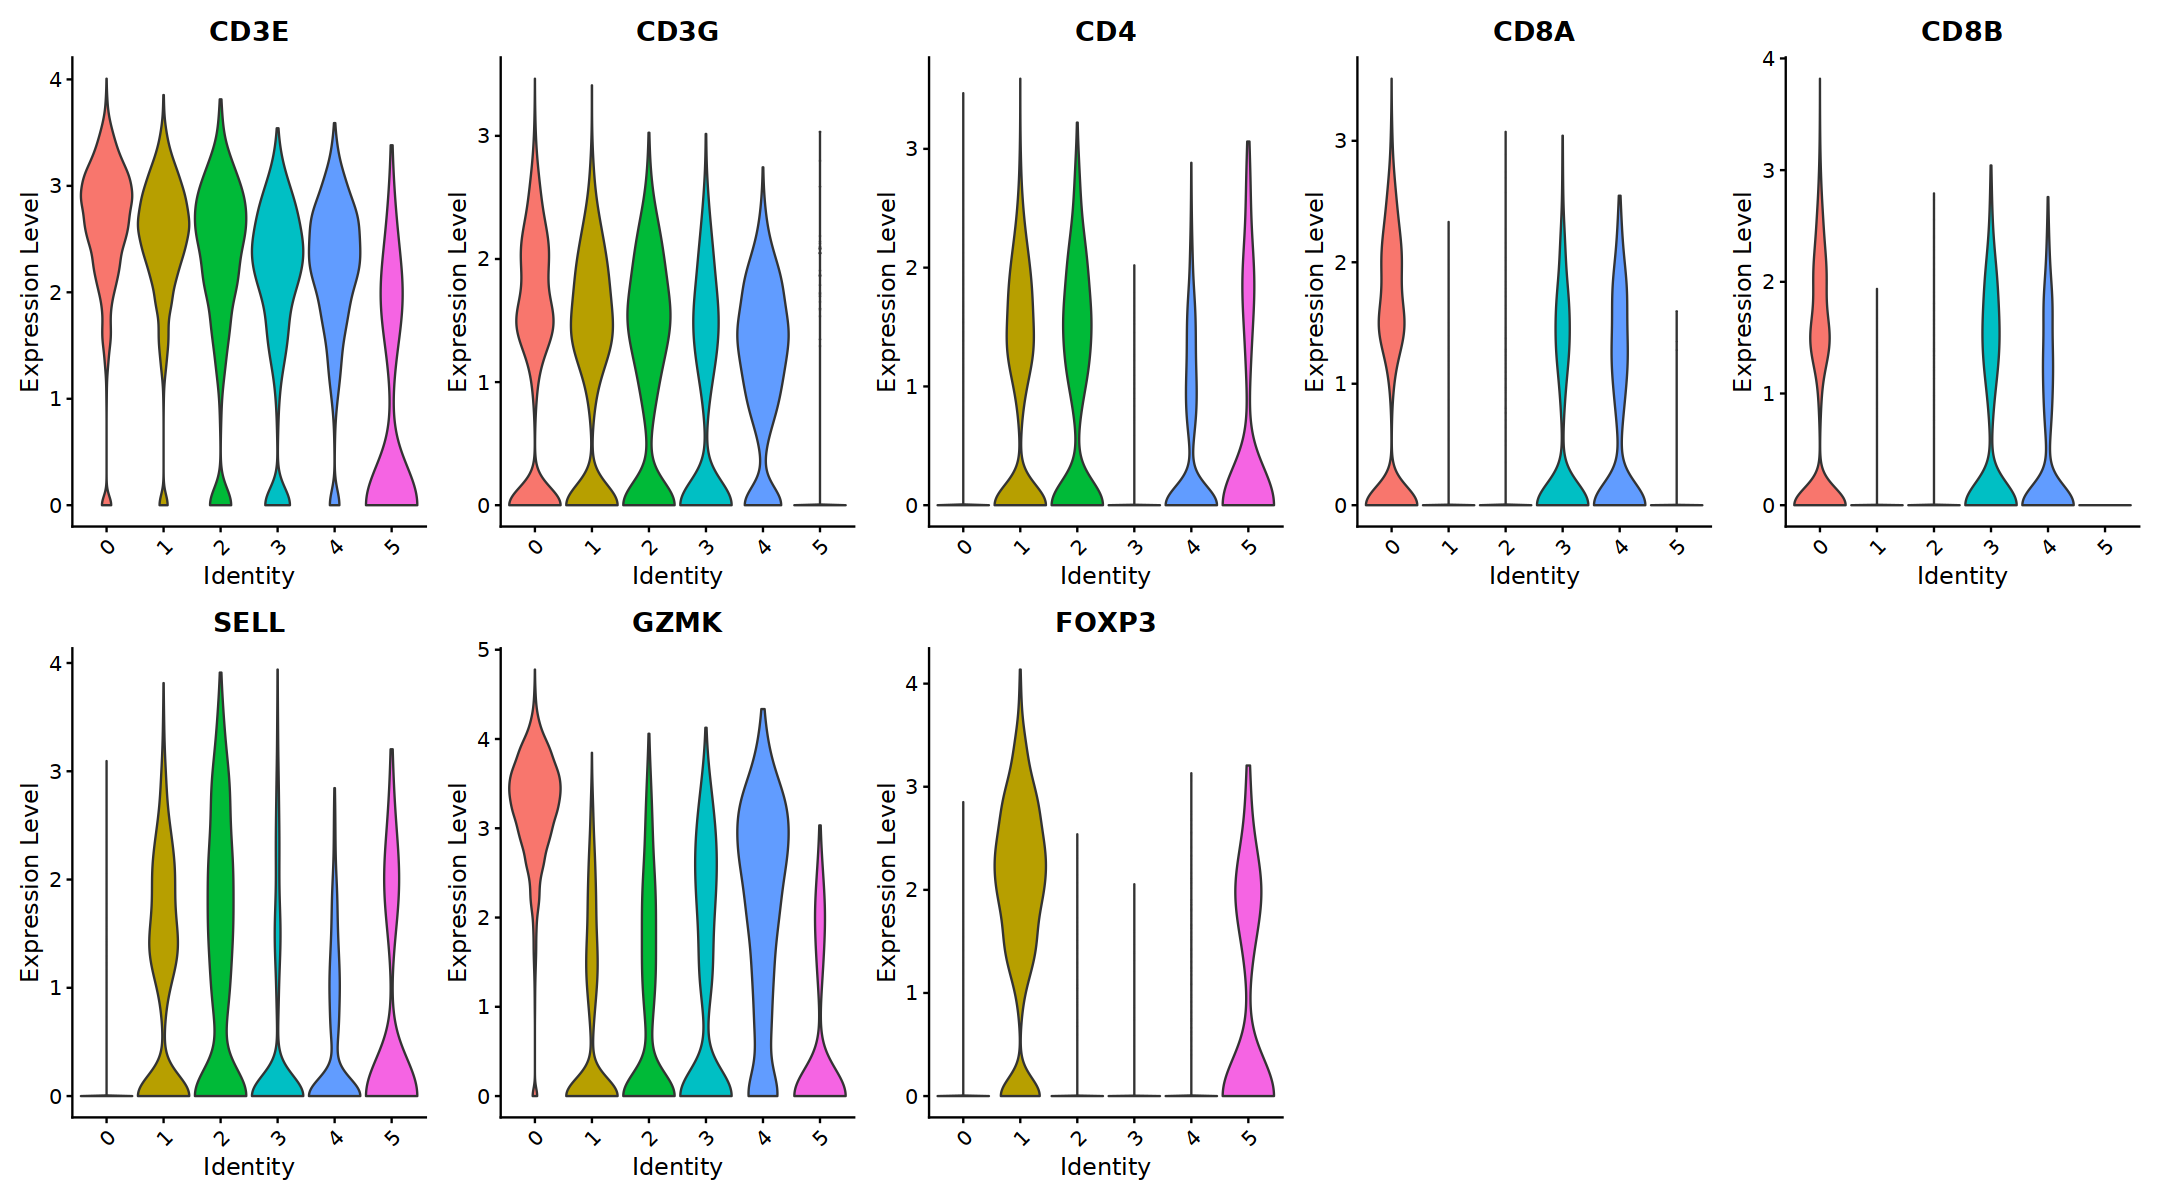

In [47]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj,features=markers, ncol=5, pt.size = 0)

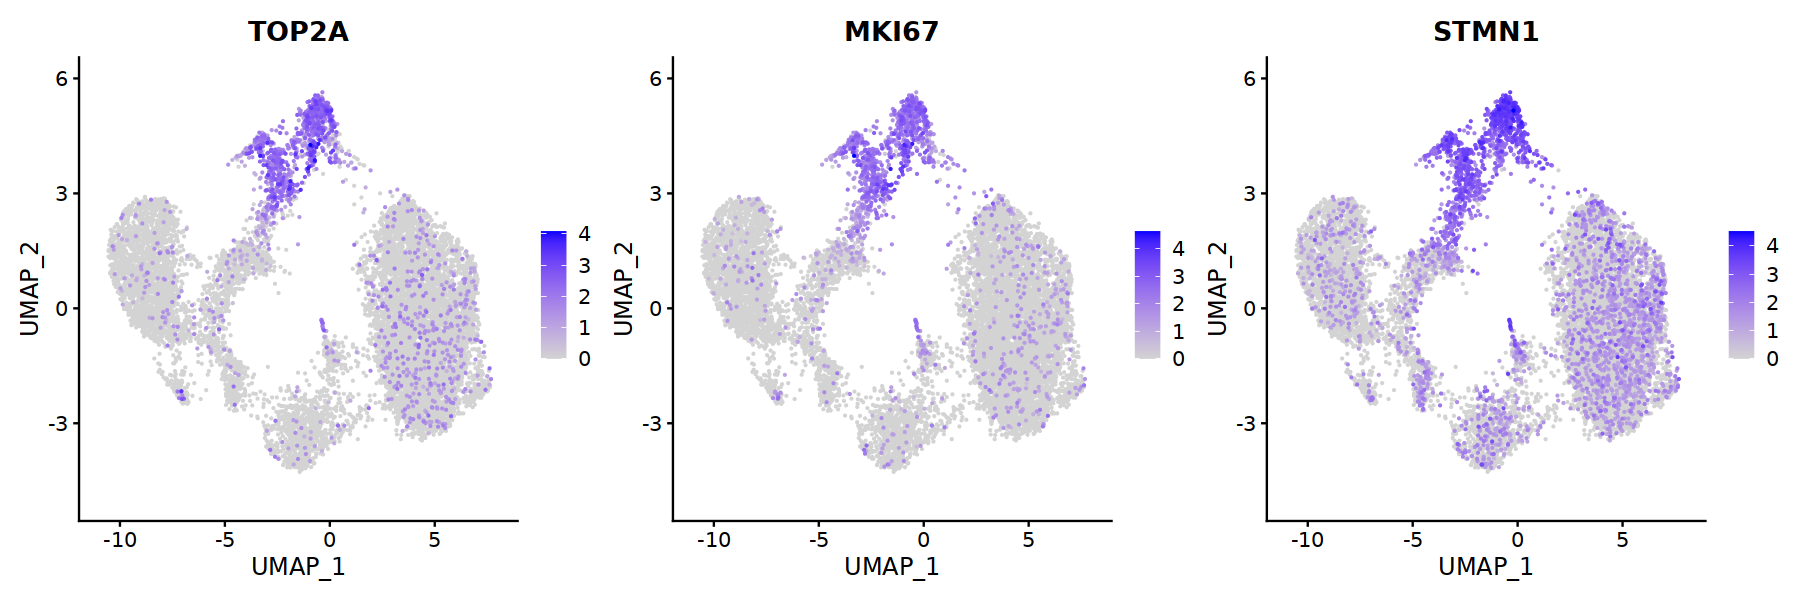

In [48]:
options(repr.plot.width = 15, repr.plot.height = 5, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, reduction = "umap", 
            features=c("TOP2A", "MKI67", "STMN1"), 
            order = TRUE, ncol=3)

# Save

In [49]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_T0_CD3pos.rds")))

In [50]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_T0_CD3pos.csv")))

# Session Info

In [51]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_